In [1]:
from cartopy import crs as ccrs
from matplotlib import pyplot as plt
from cgeniepy.model import GenieModel
import pandas as pd

## observational sst data from Tabor et al. 2016

model = GenieModel("../model/muffin.u067bc.PO4.8P8Z.SPIN", gemflag=['biogem','ecogem'])
#model = GenieModel("/Users/yingrui/Science/lgm_bcp/model/muffin.CBE.worlg4.BASESFeTDTL.SPIN", gemflag=['biogem','ecogem'])

sst = model.get_var("ocn_sur_temp").isel(time=-1)
npp = model.get_var("eco2D_Uptake_Fluxes_C").isel(time=-1)
## g C m-2 yr-1
npp = npp * 80.8 * 12 * 365 * 1E-3

sst.data.attrs['units'] = "°C"
sst.data.attrs['long_name'] = "Sea surface temperature"
npp.data.attrs['long_name'] = "Net primary production"#fig.savefig("../output/cretaceous_ocn.png", bbox_inches="tight", dpi=300)

lat = model.get_var("lat").data
sst_zonal_mean = sst.data.mean(dim="lon")
sst_zonal_sd = sst.data.std(dim="lon")
npp_zonal_mean = npp.data.mean(dim="lon")
npp_zonal_sd = npp.data.std(dim="lon")

# sst_tabor = pd.read_excel("../data/Tabor_Maastrichtian_proxy.xlsx")
# sst_tabor = sst_tabor[sst_tabor['Type']!='Planktonic forams']
sst_zhang = pd.read_csv("../data/Zhang2019.csv")

/Users/yingrui/miniforge3/envs/workspace/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yingrui/miniforge3/envs/workspace/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


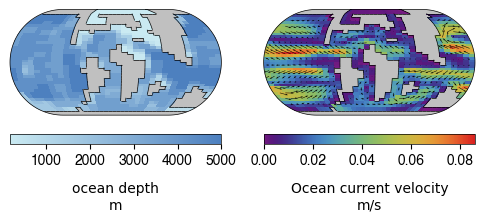

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from cgeniepy.plot import CommunityPalette
cmap = CommunityPalette("osmc_bluescale_r").colormap

# Assuming 'model' is predefined and has the necessary methods to get variables
phys_u = model.get_var("phys_u").isel(time=-1,zt=0)
phys_v = model.get_var("phys_v").isel(time=-1,zt=0)
lon = model.get_var("lon")
lat = model.get_var("lat")

# Create the figure and axis
fig, ax = plt.subplots(1,2,figsize=(6, 8), subplot_kw={'projection': ccrs.EckertIV()})

phys_uv = np.sqrt(phys_u.data**2 + phys_v.data**2)
phys_uv.attrs['long_name'] = "Ocean current velocity"
phys_uv.attrs['units'] = "m/s"
from cgeniepy.array import GriddedData
phys_uv = GriddedData(phys_uv, attrs=phys_uv.attrs).to_GriddedDataVis()
phys_uv.aes_dict['pcolormesh_kwargs']['cmap'] = CommunityPalette("tol_rainbow").colormap
phys_uv.plot(ax=ax[1], outline=True, colorbar=True)

# Plot the quiver plot
ax[1].quiver(lon, lat, phys_u.data, phys_v.data, transform=ccrs.PlateCarree(), regrid_shape=20)

grid_topo = model.get_var("grid_topo")
topo_plot = grid_topo.to_GriddedDataVis()
topo_plot.aes_dict['pcolormesh_kwargs']['cmap'] = cmap
topo_plot.plot(outline=True, colorbar=True, ax=ax[0])

## save the fig
plt.savefig("../output/cretaceous_base.png", bbox_inches="tight", dpi=300)

AttributeError: 'GriddedData' object has no attribute 'aes_dict'

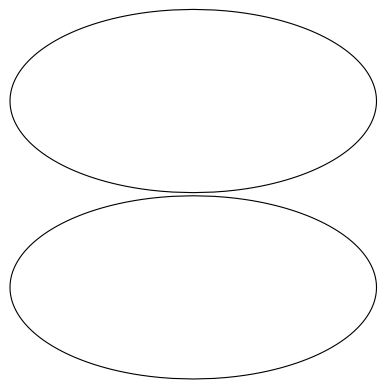

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo
import matplotlib as mpl

mpl.rcParams['pdf.fonttype']=42
## set font: Helvetica
plt.rcParams['font.family'] = 'Helvetica'

fig = plt.figure()
spec = fig.add_gridspec(20, 18)

## row ratio 1:1 (2+2)
## col ratio 2:1 (6+3)

def new_axis_right(ax):
    divider = make_axes_locatable(ax)
    ax_right = divider.new_horizontal(size="30%", pad=1, axes_class=plt.Axes)
    return ax_right

## Init figure and axes

#trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)

ax1 = fig.add_subplot(spec[:10, :14], projection=ccrs.Mollweide(central_longitude=-70))
ax2 = fig.add_subplot(spec[10:20, :14], projection=ccrs.Mollweide(central_longitude=-70))

sst.aes_dict['pcolormesh_kwargs']['cmap'] = cmo.cm.thermal
npp.aes_dict['pcolormesh_kwargs']['cmap'] = cmo.cm.haline
sst_plot = sst.plot(ax=ax1, colorbar=False,outline=True)
npp_plot = npp.plot(ax=ax2, colorbar=False,outline=True)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("left", size="3%", axes_class=plt.Axes)
cbar_sst = plt.colorbar(sst_plot, cax=cax1, orientation='vertical')
cbar_sst.set_label("SST (°C)")

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("left", size="3%", axes_class=plt.Axes)
cbar_npp = plt.colorbar(npp_plot, cax=cax2, orientation='vertical')
cbar_npp.set_label(r"NPP (g C m$^{-2}$ yr$^{-1}$)")

ax3 = fig.add_subplot(spec[1:9, 15:19])
ax3.plot(sst_zonal_mean, lat, color="k", linewidth=1)
ax3.plot(sst_zonal_mean - sst_zonal_sd, lat, color="k", linewidth=1, linestyle="--")
ax3.plot(sst_zonal_mean + sst_zonal_sd, lat, color="k", linewidth=1, linestyle="--")
ax3.set_xticks([0, 10, 20, 30])

ax4 = fig.add_subplot(spec[11:19, 15:19])
ax4.plot(npp_zonal_mean, lat, color="k", linewidth=1)
ax4.plot(npp_zonal_mean - npp_zonal_sd, lat, color="k", linewidth=1, linestyle="--")
ax4.plot(npp_zonal_mean + npp_zonal_sd, lat, color="k", linewidth=1, linestyle="--")

import seaborn as sns
#sns.scatterplot(data=sst_tabor, y="Paleo Lat", x="Proxy Temp (°C)", edgecolor = "black", ax=ax3, s=10)
sns.scatterplot(data=sst_zhang, y="Paleolatitude", x="MAT", edgecolor = "black", ax=ax3, s=10)
## sort value
#ax3.plot(sst_tabor["Maa4x Model Ann Temp (°C)"], sst_tabor["Paleo Lat"], '-o', linewidth = 0.1)

ax3.set(xlabel=None)
ax3.set(ylabel=None)

## labeling the subplots
ax1.text(0.05, 0.95, "a", transform=ax1.transAxes, fontsize=16, fontweight="bold")
ax2.text(0.05, 0.95, "b", transform=ax2.transAxes, fontsize=16, fontweight="bold")
ax3.text(-0.3, 0.95, "c", transform=ax3.transAxes, fontsize=16, fontweight="bold")
ax4.text(-0.3, 0.95, "d", transform=ax4.transAxes, fontsize=16, fontweight="bold")

## save figure
fig.savefig("../output/cretaceous_ocn.png", bbox_inches="tight", dpi=300)